# carat - onsets detection demo
<pre>
 _  _  __ _ _|_
(_ (_| | (_| |_   computer-aided rhythm analysis toolbox
</pre>

This notebook shows how to extract onsets from a recording using [carat](https://github.com/mrocamora/carat) library.

The procedure consist in computing an accentuation feature function, based on sezinig the changes in the spectral magnitude of the audio signal along different frequency bands, and peak picking in the accentuation feature function to identify onset candidates.

The following steps shows how to:

* Load audio input from file
* Compute the accentuation feature function
* Peak detection on the accentuation feature function
* Compare the detected onsets with manual annotations

### How to run the notebook
You can download the notebook and run it locally in your computer.

You can also run it in Google Colab by using the following link. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/carat/blob/master/examples/carat_onsets_detection_demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

Or you can run them using Binder directly in your browser: [![Binder](https://mybinder.org/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/mrocamora/carat/blob/master/examples/carat_microtiming_patterns_demo.ipynb)

#### Install required packages

You should install the following packages by running the next two cells.

In [1]:
!pip install carat

In [2]:
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import IPython.display as ipd

from carat import features, annotations, audio, display, onsets, util

%matplotlib inline

### 1) Load audio and onset annotations
This first step loads the audio file and the manual annotations of onsets.

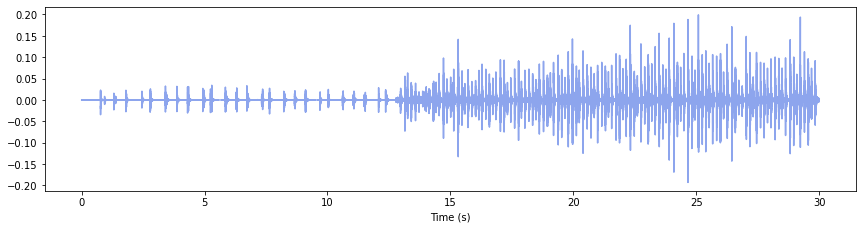

In [3]:
# use an example audio file provided
audio_path = util.example("chico_audio")

# load audio file (only 30 seconds)
y, sr = audio.load(audio_path, duration=30.0)

# time corresponding to the audio signal
time = np.arange(0, y.size)/sr

plt.figure(figsize=(12,6))
ax1 = plt.subplot(211)
display.wave_plot(y, sr, ax=ax1)
plt.tight_layout()

We can listen to the first 30 seconds of the audio file. 

**Note:** This is a separate track from a performance comprising three drums. The track corresponds to the **chico** drum, which is the timekeeper of the ensemble. The performance starts by playing the **clave** pattern (timeline pattern). After a few rhythmic cycles the **chico** drum starts playing an ostinato pattern that articulates the four subdivisions of the beat.

In [4]:
ipd.Audio(y, rate=sr)

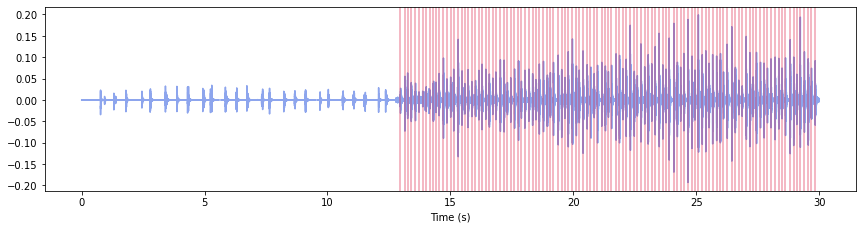

In [5]:
# use onset annotations provided for the example audio file
onset_annotations_file = util.example("chico_onsets")

# load onset annotations
onsets_ann, _ = annotations.load_onsets(onset_annotations_file)

# plot waveform and beats for the first 30 seconds
plt.figure(figsize=(12,6))
ax1 = plt.subplot(211)
display.wave_plot(y, sr, ax=ax1, onsets=onsets_ann)
plt.tight_layout()

### 2) Compute the accentuation feature function

This second step show how to compute an accentuation feature from the audio waveform based on the [Spectral flux](https://en.wikipedia.org/wiki/Spectral_flux), that consists in seizing the changes in the spectral magnitude of the audio signal along different frequency bands. In principle, the feature value is high when a note has been articulated and close to zero otherwise.

**Note:** This example is tailored towards the onsets of the *chico* drum, the highest sounding of the three candombe drum types, so the analysis focuses on the higher frequencies (500 to 3000 Hz). Some other parameters are also tweaked, such as the hop size for computing the spectrogram.

In [6]:
hop = 5e-3            # hop size
nfilts = 80           # Number of MEL filters
log_flag = True       # If LOG should be taken before taking differentiation
alpha = 10e4          # compression parameter for dB conversion - log10(alpha*abs(S)+1)
freqs = [500, 3000]   # chico bound frequencies for summing frequency band

acce, times, _ = features.accentuation_feature(y, sr, hop=hop, nfilts=nfilts, log_flag=log_flag, alpha=alpha,
                                               minfreq=freqs[0], maxfreq=freqs[1])


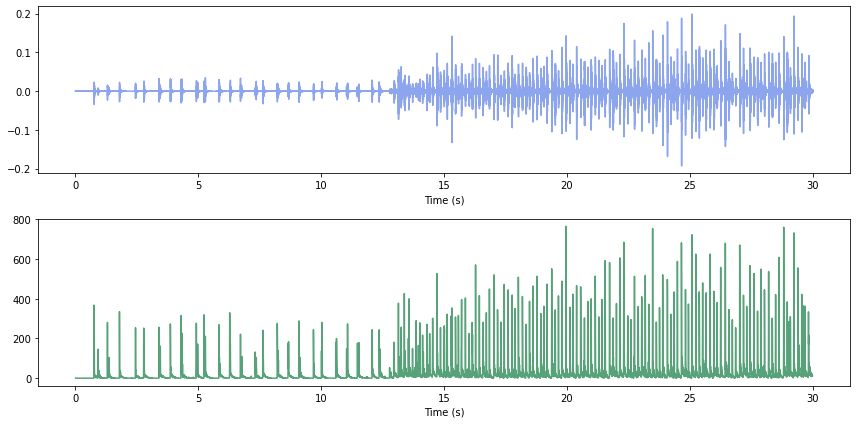

In [7]:
# plot waveform and accentuation feature
plt.figure(figsize=(12,6))
# plot waveform
ax1 = plt.subplot(2, 1, 1)
display.wave_plot(y, sr, ax=ax1)
# plot accentuation feature
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
display.feature_plot(acce, times, ax=ax2)
plt.tight_layout()

### 3) Peak detection on the accentuation feature function

For peak picking, following a method proposed in [1] and later modified in [2], a set of simple peak selection rules are implemented in which onset candidates, apart from being a local maximum, have to exceed a threshold that is a combination of a fixed and an adaptive value.

In [8]:
threshd = 0.180   # threshold for peak-picking (chico)
pre_avg = 14      # number of past frames for moving average
pos_avg = 10      # number of future frames for moving average
pre_max = 14      # number of past frames for moving maximum
pos_max = 10      # number of future frames for moving maximum

peak_indxs, mov_avg, mov_max = features.peak_detection(acce, threshold=threshd, 
                                                       pre_avg=pre_avg, pos_avg=pos_avg, 
                                                       pre_max=pre_max, pos_max=pos_max)

# time instants of the onsets
onset_times = times[peak_indxs]

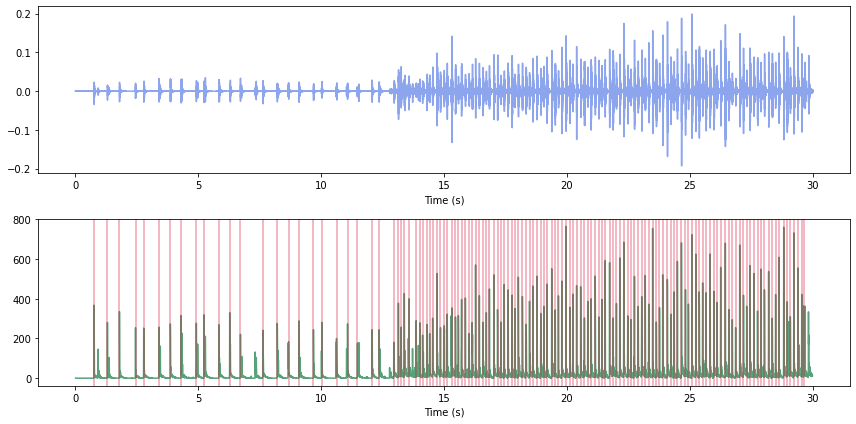

In [9]:
# plot waveform and accentuation feature
plt.figure(figsize=(12,6))
# plot waveform
ax1 = plt.subplot(2, 1, 1)
display.wave_plot(y, sr, ax=ax1)
# plot accentuation feature and detected onsets
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
display.feature_plot(acce, times, ax=ax2, onsets=onset_times)
plt.tight_layout()

### 4) Onset detection with only one function

All of the above can be done by using a single function, called `onsets.detection()`, as shown bellow. Note that you can specify all the parameters values that are used in the process by the low level functions, such as `features.accentuation_feature` or `features.peak_detection`.

In [10]:
onsets_all, _ = onsets.detection(y, fs=sr, hop=hop, nfilts=nfilts, log_flag=log_flag, alpha=alpha,
                                 minfreq=freqs[0], maxfreq=freqs[1], threshold=threshd,
                                 pre_avg=pre_avg, pos_avg=pos_avg, pre_max=pre_max, pos_max=pos_max)


We can now check if the onsets obtained are the same.

In [11]:
# check if the onsets obtained are the same
np.testing.assert_allclose(onset_times, onsets_all)

### 5) Compare the detected onsets with manual annotations

In the following plot we depict the detected onsets with the manual annotations side by side to compare them visually. 

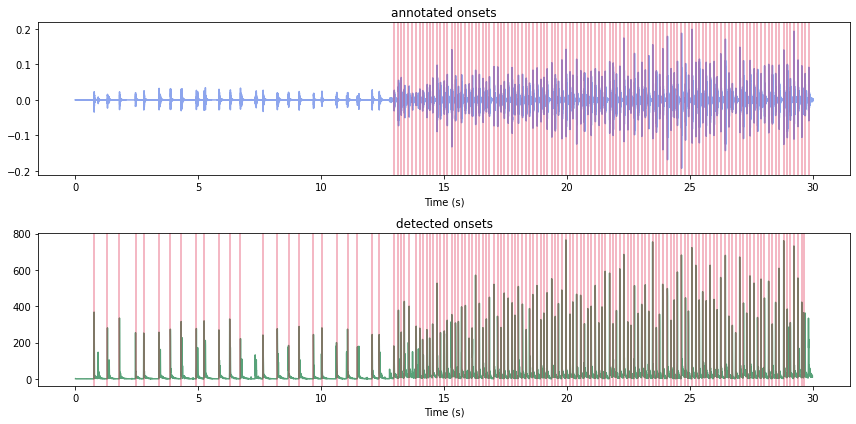

In [12]:
# plot waveform and annotated onsets
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
display.wave_plot(y, sr, ax=ax1, onsets=onsets_ann)
plt.title('annotated onsets')
# plot accentuation feature and detected onsets
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
display.feature_plot(acce, times, ax=ax2, onsets=onset_times)
plt.title('detected onsets')

plt.tight_layout()

**Note:** The first difference we can notice is that there are several detected onsets at the begining that were not annotated. This is beacuse they do not correspond to the typicall **chico** ostinato parttern the annotator was interested in. Recall that the performance starts by playing the **clave** pattern (timeline pattern). After a few rhythmic cycles the **chico** drum starts playing an ostinato pattern that articulates the four subdivisions of the beat. This is the annotated pattern. Besides, an onset is missing in the automatic detection (around second 14). You could try to tweak the parameters to fix it, or save the onsets to a csv file and edit it in [SonicVisualiser](https://sonicvisualiser.org/). 

### 5) Save the detected onsets to a csv file

Now that we detected the onsets we can save them to a csv file. 

In [13]:
annotations.save_onsets("detected_onsets_chico.csv", onset_times)